In [10]:
#%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import Imputer
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from collections import Counter
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
dataset = pd.read_csv('../../data/full_dataset/full_data_new_features.csv')
dataset = dataset.drop(dataset.columns[0], axis = 1)
dataset_set = set(dataset)
dataset.head()

,TLE4_PCA,TLE4_LDA,TLE4_mean,TLE4_variance,IGF2BP2_PCA,IGF2BP2_LDA,IGF2BP2_mean,IGF2BP2_variance,NOTCH2_PCA,NOTCH2_LDA,...,CHIC1_variance,ATRX_PCA,ATRX_LDA,ATRX_mean,ATRX_variance,CHM_PCA,CHM_LDA,CHM_mean,CHM_variance,labels
0,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,0.315317,-0.009725,...,0.0,-0.640449,0.923010,2.0,0.0,-0.371366,-0.19022,0.000000,0.000000,1
1,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,0.634513,0.409493,...,0.0,1.359551,-1.959372,0.0,0.0,-0.371366,-0.19022,0.000000,0.000000,1
2,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,-0.949195,1.280339,...,0.0,1.359551,-1.959372,0.0,0.0,-0.371366,-0.19022,0.000000,0.000000,1
3,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,1.081059,-1.659938,...,0.0,1.359551,-1.959372,0.0,0.0,0.429555,3.94475,0.666667,0.888889,1
4,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,0.315317,-0.009725,...,0.0,-0.640449,0.923010,2.0,0.0,-0.371366,-0.19022,0.000000,0.000000,1


In [3]:
# Start by only using known risk genes
# at: data/knownvariants/risk_genes.csv

knownvariants = pd.read_csv('../../data/knownvariants/risk_genes.csv', sep = ';')
locus_set = set(knownvariants['Locus'])
knownvariants.head()

,Locus,Chr,Risk allele frequency,OR (95%CI)
0,NOTCH2,1,0.11,1.13 (1.08-1.17)
1,PROX1,1,0.50,1.07 (1.05-1.09)
2,IRS1,2,0.61,1.19 (1.13-1.25)
3,THADA,2,0.92,1.15 (1.10-1.20)
4,RBMS1/ITGB6,2,0.57,1.11 (1.08-1.16)


In [4]:
# making list of features
risk_features = []
for feature in list(dataset):
    for locus in knownvariants['Locus']:
        if locus in feature:
            risk_features.append(feature)

dataset_risk_genes = dataset[risk_features]
dataset_risk_genes.head()

,TLE4_PCA,TLE4_LDA,TLE4_mean,TLE4_variance,IGF2BP2_PCA,IGF2BP2_LDA,IGF2BP2_mean,IGF2BP2_variance,NOTCH2_PCA,NOTCH2_LDA,...,PPARG_mean,PPARG_variance,ZFAND6_PCA,ZFAND6_LDA,ZFAND6_mean,ZFAND6_variance,CDKAL1_PCA,CDKAL1_LDA,CDKAL1_mean,CDKAL1_variance
0,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,0.315317,-0.009725,...,0.0,0.0,-0.218702,-0.489841,0.0,0.00,-0.272613,0.051311,0.333333,0.444444
1,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,0.634513,0.409493,...,0.0,0.0,1.780863,4.051640,1.0,1.00,-1.352588,0.737521,0.444444,0.691358
2,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,-0.949195,1.280339,...,0.0,0.0,-0.218702,-0.489841,0.0,0.00,-0.478563,-0.776670,0.444444,0.469136
3,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,1.081059,-1.659938,...,0.0,0.0,-0.218702,-0.489841,0.0,0.00,-0.713995,0.880211,0.222222,0.395062
4,-0.073001,-0.253146,0.0,0.0,-0.229009,-0.181177,0.0,0.0,0.315317,-0.009725,...,0.0,0.0,0.781081,1.780900,0.5,0.25,-0.855654,0.087939,0.444444,0.469136


In [168]:
X_train, X_test, y_train, y_test = train_test_split(dataset_risk_genes, dataset['labels'], test_size = 0.3)

# Random Forest Model
rf_model = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
rf_model.fit(X_train, y_train)

# To save model
#joblib.dump(rf_model, '../../data/rf_model.pkl') 

# Predicting
# y_predicted = rf_model.predict(X_test)
y_predicted = cross_val_predict(rf_model, X_test, y_test, cv=5)
# print(confusion_matrix(y_test, y_predicted))

print('F1-score: ' + str(f1_score(y_test, y_predicted, average = 'micro')))

# Saving f1 score and all indexes
importances = rf_model.feature_importances_
importances_indexes = np.argsort(importances)[::-1]
importances_indexes = importances_indexes[0:10]


F1-score: 0.8333333333333334


# 1. Defining best parameters for only risk genes classifiers

In [170]:
param_grid = [
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['gini'],
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['entropy'], 
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
]

extra_class = ExtraTreesClassifier()
grid_search = GridSearchCV(extra_class, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_search.best_estimator_


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=50,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [171]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, risk_features), reverse=True)

[(0.3003876742759069, 'GCK_LDA'),
 (0.07888130312173368, 'KCNQ1_LDA'),
 (0.06605648454644202, 'ADAMTS9_LDA'),
 (0.06523710463071379, 'KCNQ1_LDA'),
 (0.06244633835786666, 'WFS1_LDA'),
 (0.020762128222743353, 'NOTCH2_LDA'),
 (0.016358114964701964, 'NOTCH2_mean'),
 (0.01625452798399663, 'NOTCH2_PCA'),
 (0.014170525743576568, 'WFS1_mean'),
 (0.014169212646935624, 'CDKAL1_PCA'),
 (0.013621749718323839, 'THADA_LDA'),
 (0.01309847629342091, 'PRC1_mean'),
 (0.01292772814315217, 'IGF2BP2_mean'),
 (0.012797758892638574, 'NOTCH2_variance'),
 (0.012466446660996831, 'TLE4_variance'),
 (0.012411015561411873, 'ZFAND6_PCA'),
 (0.01154453495715563, 'TLE4_mean'),
 (0.01024501724738283, 'THADA_PCA'),
 (0.01021866894475044, 'ADCY5_LDA'),
 (0.009960615806320253, 'ADAMTS9_PCA'),
 (0.008902421304657673, 'WFS1_variance'),
 (0.008767559505172022, 'PRC1_variance'),
 (0.008735827934869649, 'GCK_PCA'),
 (0.008214490405443853, 'ADAMTS9_mean'),
 (0.008021113575278583, 'ADCY5_PCA'),
 (0.007611271068206418, 'GCK_vari

In [147]:
# from: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



F1-score: 0.8518518518518519


<IPython.core.display.Javascript object>


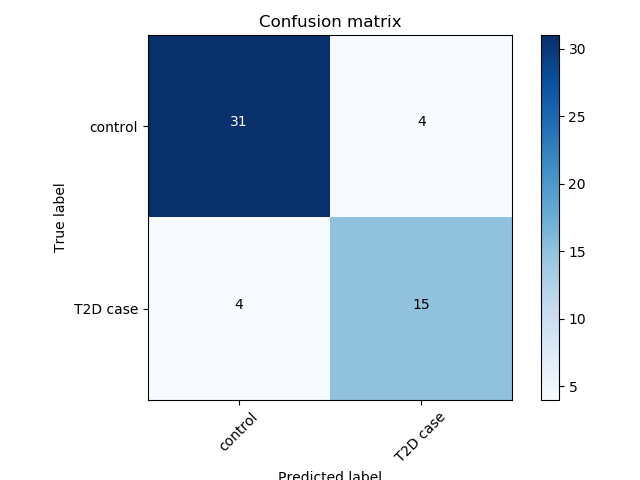

Confusion matrix, without normalization
[[31  4]
 [ 4 15]]


In [148]:
y_predicted = grid_search.best_estimator_.predict(X_test)
print('F1-score: ' + str(f1_score(y_test, y_predicted, average = 'micro')))
cnf_matrix = confusion_matrix(y_test, y_predicted)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['control','T2D case'],
                      title='Confusion matrix')

# 1.1 Using only the top 25 features

In [149]:
top_features = sorted(zip(feature_importances, risk_features), reverse=True)
top_features_25 = top_features[0:40]
top_features_25 = [x[1] for x in top_features_25]


In [150]:
X_train, X_test, y_train, y_test = train_test_split(dataset_risk_genes[top_features_25], dataset['labels'], test_size = 0.3)

param_grid = [
    {'n_estimators': [50, 75, 100], 'max_features':[None], 'criterion': ['gini'], 'max_leaf_nodes': [2, 20, 50, 75, 100, 125, 150], 'n_jobs':[-1], 'bootstrap': [False]},
    {'n_estimators': [50, 75, 100], 'max_features':[None], 'criterion': ['entropy'], 'max_leaf_nodes': [2, 20, 50, 75, 100, 125, 150], 'n_jobs':[-1], 'bootstrap': [False]},
]

extra_class = ExtraTreesClassifier()
grid_search = GridSearchCV(extra_class, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

grid_search.best_estimator_


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

F1-score: 0.8333333333333334


<IPython.core.display.Javascript object>


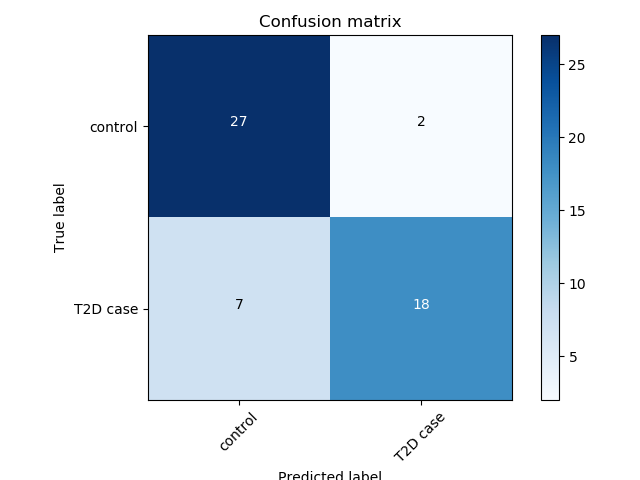

Confusion matrix, without normalization
[[27  2]
 [ 7 18]]


In [151]:
y_predicted = grid_search.best_estimator_.predict(X_test)
print('F1-score: ' + str(f1_score(y_test, y_predicted, average = 'micro')))
cnf_matrix = confusion_matrix(y_test, y_predicted)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['control','T2D case'],
                      title='Confusion matrix')

In [153]:
grid_search.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=100,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [5]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

# 1.2 Average for 100 runs with best parameters (only risk genes)

In [14]:
# Run several classifiers and find wich variants appear more

#Classifiers:
'''
CLASSIFIER 1
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=50,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

average accuracy: 0.74
average f1-score: 0.62

CLASSIFIER 2
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=None, max_leaf_nodes=50,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

average accuracy: 
average f1-score: 0.74

CLASSIFIER 3
ExtraTreesClassifier(n_estimators=50, n_jobs=-1)

average f1-score: 0.68


'''


f1_scores = []
accuracies = []
recalls = []
top_variants = np.array([])
dataset_list = list(dataset_risk_genes)
for run in range(0, 100):
    # Dividing train and test
    X_train, X_test, y_train, y_test = train_test_split(dataset_risk_genes, dataset['labels'], test_size = 0.3)

    print('Fitting model number: '  + str(run))

    # Random Forest Model
    rf_model = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=50,
           min_samples_leaf=3, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
    rf_model.fit(X_train, y_train)

    # To save model
    #joblib.dump(rf_model, '../../data/rf_model.pkl') 

    print('Predicting...')

    # Predicting
    # y_predicted = rf_model.predict(X_test)
    y_predicted = cross_val_predict(rf_model, X_test, y_test, cv=5)
    # print(confusion_matrix(y_test, y_predicted))

    print('F1-score: ' + str(f1_score(y_test, y_predicted)) + '\nAccuracy: ' + \
         str(accuracy_score(y_pred = y_predicted, y_true = y_test)) + \
         '\nRecall: ' + str(recall_score(y_true=y_test, y_pred=y_predicted)))
    
    f1_scores.append(f1_score(y_test, y_predicted))
    accuracies.append(accuracy_score(y_pred = y_predicted, y_true = y_test))
    recalls.append(recall_score(y_true=y_test, y_pred=y_predicted))

# Results and important features
f1s = mean(f1_scores)
accuracy_mean = mean(accuracies)
recall_mean = mean(recalls)
print('Final f1 score: ' + str(f1s) + '\nFinal Accuraccy: ' + str(accuracy_mean))
frequencies = Counter(top_variants)


Fitting model number: 0
Predicting...
F1-score: 0.571428571429
Accuracy: 0.777777777778
Recall: 0.444444444444
Fitting model number: 1
Predicting...
F1-score: 0.48275862069
Accuracy: 0.722222222222
Recall: 0.388888888889
Fitting model number: 2
Predicting...
F1-score: 0.68085106383
Accuracy: 0.722222222222
Recall: 0.666666666667
Fitting model number: 3
Predicting...
F1-score: 0.5
Accuracy: 0.740740740741
Recall: 0.368421052632
Fitting model number: 4
Predicting...
F1-score: 0.577777777778
Accuracy: 0.648148148148
Recall: 0.52
Fitting model number: 5
Predicting...
F1-score: 0.615384615385
Accuracy: 0.722222222222
Recall: 0.521739130435
Fitting model number: 6
Predicting...
F1-score: 0.648648648649
Accuracy: 0.759259259259
Recall: 0.571428571429
Fitting model number: 7
Predicting...
F1-score: 0.625
Accuracy: 0.777777777778
Recall: 0.588235294118
Fitting model number: 8
Predicting...
F1-score: 0.68
Accuracy: 0.703703703704
Recall: 0.68
Fitting model number: 9
Predicting...
F1-score: 0.666

F1-score: 0.514285714286
Accuracy: 0.685185185185
Recall: 0.45
Fitting model number: 78
Predicting...
F1-score: 0.666666666667
Accuracy: 0.777777777778
Recall: 0.571428571429
Fitting model number: 79
Predicting...
F1-score: 0.666666666667
Accuracy: 0.777777777778
Recall: 0.571428571429
Fitting model number: 80
Predicting...
F1-score: 0.529411764706
Accuracy: 0.703703703704
Recall: 0.428571428571
Fitting model number: 81
Predicting...
F1-score: 0.744186046512
Accuracy: 0.796296296296
Recall: 0.761904761905
Fitting model number: 82
Predicting...
F1-score: 0.722222222222
Accuracy: 0.814814814815
Recall: 0.65
Fitting model number: 83
Predicting...
F1-score: 0.782608695652
Accuracy: 0.814814814815
Recall: 0.72
Fitting model number: 84
Predicting...
F1-score: 0.791666666667
Accuracy: 0.814814814815
Recall: 0.791666666667
Fitting model number: 85
Predicting...
F1-score: 0.739130434783
Accuracy: 0.777777777778
Recall: 0.68
Fitting model number: 86
Predicting...
F1-score: 0.893617021277
Accurac

# 2. Testing with the full dataset

In [6]:
pre_X = dataset.drop('labels', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

param_grid = [
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['gini'],
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['entropy'], 
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
]

extra_class_full = ExtraTreesClassifier()
grid_search_full = GridSearchCV(extra_class_full, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_full.fit(X_train, y_train)

grid_search_full.best_estimator_


KeyboardInterrupt: 

In [179]:
feature_importances = grid_search_full.best_estimator_.feature_importances_
sorted(zip(feature_importances, list(dataset)), reverse=True)

[(0.15863306529747578, 'EVPLL_LDA'),
 (0.1190207033855199, 'EVPLL_PCA'),
 (0.11077725896940843, 'FAM71E2_LDA'),
 (0.0655365774602478, 'FAM71E2_mean'),
 (0.06110208621203839, 'FAM71E2_PCA'),
 (0.041649637040476944, 'MAGEB3_variance'),
 (0.030874866507669855, 'TAB3_mean'),
 (0.028893464585997872, 'TAB3_LDA'),
 (0.027381810540270952, 'GPC4_PCA'),
 (0.024760325462171676, 'EVPLL_mean'),
 (0.022236787567358522, 'FAM120C_PCA'),
 (0.01818144080567339, 'GPC4_mean'),
 (0.01653289961173324, 'ECI1_mean'),
 (0.016211873811216897, 'NGLY1_LDA'),
 (0.01469771390058074, 'GPC4_LDA'),
 (0.0140044512444493, 'ECI1_PCA'),
 (0.013611192532162879, 'TAB3_PCA'),
 (0.013114469462480974, 'GABRA3_LDA'),
 (0.012659995547907199, 'SLC38A5_LDA'),
 (0.01175156933469532, 'WFS1_LDA'),
 (0.011055902429665304, 'ECI1_LDA'),
 (0.009959633798203162, 'FAM120C_mean'),
 (0.00965682491560716, 'FRMD7_LDA'),
 (0.009447803025579802, 'THADA_mean'),
 (0.008704332230462212, 'MAGEB3_LDA'),
 (0.008230863750131424, 'NGLY1_mean'),
 (0.0077

In [29]:
'''
CLASSIFIER 1
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
           
average f1-score: 0.79
'''


def extra_trees(dataset):
    
    f1_scores = []
    top_variants = np.array([])
    dataset_list = np.array(list(dataset))
    for run in range(0, 100):
        # Dividing train and test
        pre_X = dataset.drop('labels', axis = 1)
        X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

        print('Fitting model number: '  + str(run))

        # Random Forest Model
        rf_model = ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

        rf_model.fit(X_train, y_train)

        # To save model
        #joblib.dump(rf_model, '../../data/rf_model.pkl') 

        print('Predicting...')

        # Predicting
        # y_predicted = rf_model.predict(X_test)
        y_predicted = cross_val_predict(rf_model, X_test, y_test, cv=5)
        # print(confusion_matrix(y_test, y_predicted))

        # Saving f1 score and all indexes
        importances = rf_model.feature_importances_
        importances_indexes = np.argsort(importances)[::-1]
        importances_indexes = importances_indexes[0:100]

        print('F1-score: ' + str(f1_score(y_test, y_predicted)))
        f1_scores.append(f1_score(y_test, y_predicted))
        top_variants = np.concatenate((top_variants, dataset_list[importances_indexes]))


    # Results and important features
    f1s = mean(f1_scores)
    frequencies = Counter(top_variants)

    print('Final f1 score: ' + str(f1s))
    
    return((f1s, f1_scores, frequencies))
    


In [17]:
(f1s, f1_scores, frequencies) = extra_trees(dataset)

Fitting model number: 0
Predicting...
F1-score: 0.75
Fitting model number: 1
Predicting...
F1-score: 0.604651162791
Fitting model number: 2
Predicting...
F1-score: 0.736842105263
Fitting model number: 3
Predicting...
F1-score: 0.809523809524
Fitting model number: 4
Predicting...
F1-score: 0.666666666667
Fitting model number: 5
Predicting...
F1-score: 0.872727272727
Fitting model number: 6
Predicting...
F1-score: 0.837209302326
Fitting model number: 7
Predicting...
F1-score: 0.684210526316
Fitting model number: 8
Predicting...
F1-score: 0.867924528302
Fitting model number: 9
Predicting...
F1-score: 0.864864864865
Fitting model number: 10
Predicting...
F1-score: 0.808510638298
Fitting model number: 11
Predicting...
F1-score: 0.652173913043
Fitting model number: 12
Predicting...
F1-score: 0.8
Fitting model number: 13
Predicting...
F1-score: 0.833333333333
Fitting model number: 14
Predicting...
F1-score: 0.705882352941
Fitting model number: 15
Predicting...
F1-score: 0.897959183673
Fitting

## 2.1 Selecting top features for classifier

In [18]:
frequencies_plot_info = pd.DataFrame(columns = ['variant', 'frequency'])

count = 0
for key in frequencies.keys():
    frequencies_plot_info.loc[count] = [key, frequencies[key]]
    count += 1

frequencies_plot_info.head()

,variant,frequency
0,FAM71E2_LDA,100
1,FAM71E2_mean,100
2,FAM71E2_PCA,100
3,GPC4_mean,93
4,FAM120C_PCA,96


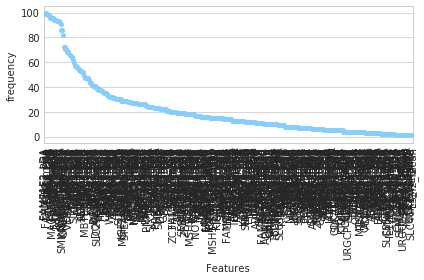

In [19]:
frequencies_plot_info['frequency'].astype(int, inplace = True)
frequencies_plot_info.sort_values(by = 'frequency', ascending = False, inplace = True)

plt.figure()
sns.set_style("whitegrid")
plot = sns.swarmplot(x = "variant", y = "frequency", data = frequencies_plot_info, color = "lightskyblue")
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)
#plot.get_xaxis().set_visible(False)
plt.xlabel('Features')
plt.tight_layout()
plt.show()

In [20]:
top_features = frequencies_plot_info.iloc[0:50, 0]
top_features = list(top_features)
top_features.append('labels')
top_features

# New dataset
top50_dataset = dataset[list(top_features)]
top50_dataset.head()


,FAM71E2_LDA,FAM71E2_PCA,FAM71E2_mean,EVPLL_PCA,EVPLL_LDA,GCK_LDA,TAB3_LDA,GPC4_LDA,SLC38A5_LDA,MAGEB3_variance,...,PLCD1_LDA,PLCD1_mean,PRR3_mean,PRR3_PCA,GCKR_mean,IGF2BP2_LDA,PLCD1_PCA,SERTM1_mean,ADAMTS9_LDA,labels
0,-0.978452,-0.871782,0.0,-0.407446,0.859112,-0.608028,0.778193,0.778193,0.724782,0.64,...,-0.35971,0.0,1.0,0.426966,0.00,-0.181177,-0.11236,0.0,-0.234393,1
1,-0.978452,-0.871782,0.0,-0.407446,0.859112,-0.119657,0.778193,0.778193,0.724782,0.64,...,-0.35971,0.0,2.0,-0.573034,0.25,-0.181177,-0.11236,1.0,1.243810,1
2,1.855746,1.954985,2.0,-0.407446,0.859112,0.007076,0.778193,0.778193,0.724782,0.64,...,-0.35971,0.0,2.0,-0.573034,0.50,-0.181177,-0.11236,0.0,3.194910,1
3,2.673006,0.590042,1.0,-0.407446,0.859112,1.562383,0.778193,0.778193,0.724782,0.96,...,-0.35971,0.0,1.0,0.426966,0.25,-0.181177,-0.11236,0.5,0.291459,1
4,0.438647,0.541601,1.0,-0.407446,0.859112,1.140437,0.778193,0.778193,0.724782,0.64,...,-0.35971,0.0,2.0,-0.573034,0.25,-0.181177,-0.11236,0.5,-0.492642,1


## 2.2 Classify with top 50 features

In [60]:
pre_X = top50_dataset.drop('labels', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(pre_X, top50_dataset['labels'], test_size = 0.3)

param_grid = [
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['gini'],
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
    {'n_estimators': [25, 50, 75, 100], 'max_features':[None], 'criterion': ['entropy'], 
     'min_samples_leaf':[1,2,3,5,10], 'min_samples_split':[2,4,5,8,10],
     'max_leaf_nodes': [2, 20, 50, 75, 100], 'n_jobs':[-1], 'bootstrap': [False]},
]

extra_class_full = ExtraTreesClassifier()
grid_search_full = GridSearchCV(extra_class_full, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_full.fit(X_train, y_train)

grid_search_full.best_estimator_

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [30]:
'''
CLASSIFIER 1
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='entropy',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_samples_leaf=5, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
           
average f1-score: 0.84

CLASSIFIER 2
ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features=None, max_leaf_nodes=20,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
           
average f1-score: 0.87

'''

(f1s, f1_scores, frequencies) = extra_trees(top50_dataset)

Fitting model number: 0
Predicting...
F1-score: 0.9
Fitting model number: 1
Predicting...
F1-score: 0.976744186047
Fitting model number: 2
Predicting...
F1-score: 0.8
Fitting model number: 3
Predicting...
F1-score: 0.875
Fitting model number: 4
Predicting...
F1-score: 0.916666666667
Fitting model number: 5
Predicting...
F1-score: 0.901960784314
Fitting model number: 6
Predicting...
F1-score: 0.842105263158
Fitting model number: 7
Predicting...
F1-score: 0.765957446809
Fitting model number: 8
Predicting...
F1-score: 0.905660377358
Fitting model number: 9
Predicting...
F1-score: 0.857142857143
Fitting model number: 10
Predicting...
F1-score: 0.857142857143
Fitting model number: 11
Predicting...
F1-score: 0.904761904762
Fitting model number: 12
Predicting...
F1-score: 0.96
Fitting model number: 13
Predicting...
F1-score: 0.909090909091
Fitting model number: 14
Predicting...
F1-score: 0.85
Fitting model number: 15
Predicting...
F1-score: 0.894736842105
Fitting model number: 16
Predicting..

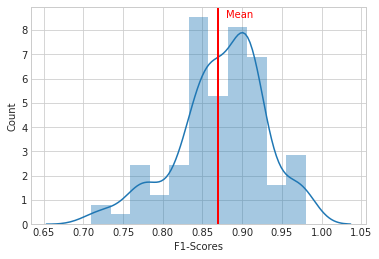

In [31]:
plt.figure()
sns.distplot(f1_scores)
plt.xlabel('F1-Scores')
plt.ylabel('Count')
plt.plot([0.87, 0.87], [0, 12], 'r-', lw=2)
plt.text(s = 'Mean', y = 8.5, x = 0.88, color = 'red')
plt.savefig("../../data/plots/f1s_top_50_rf/2.png") 
plt.show()

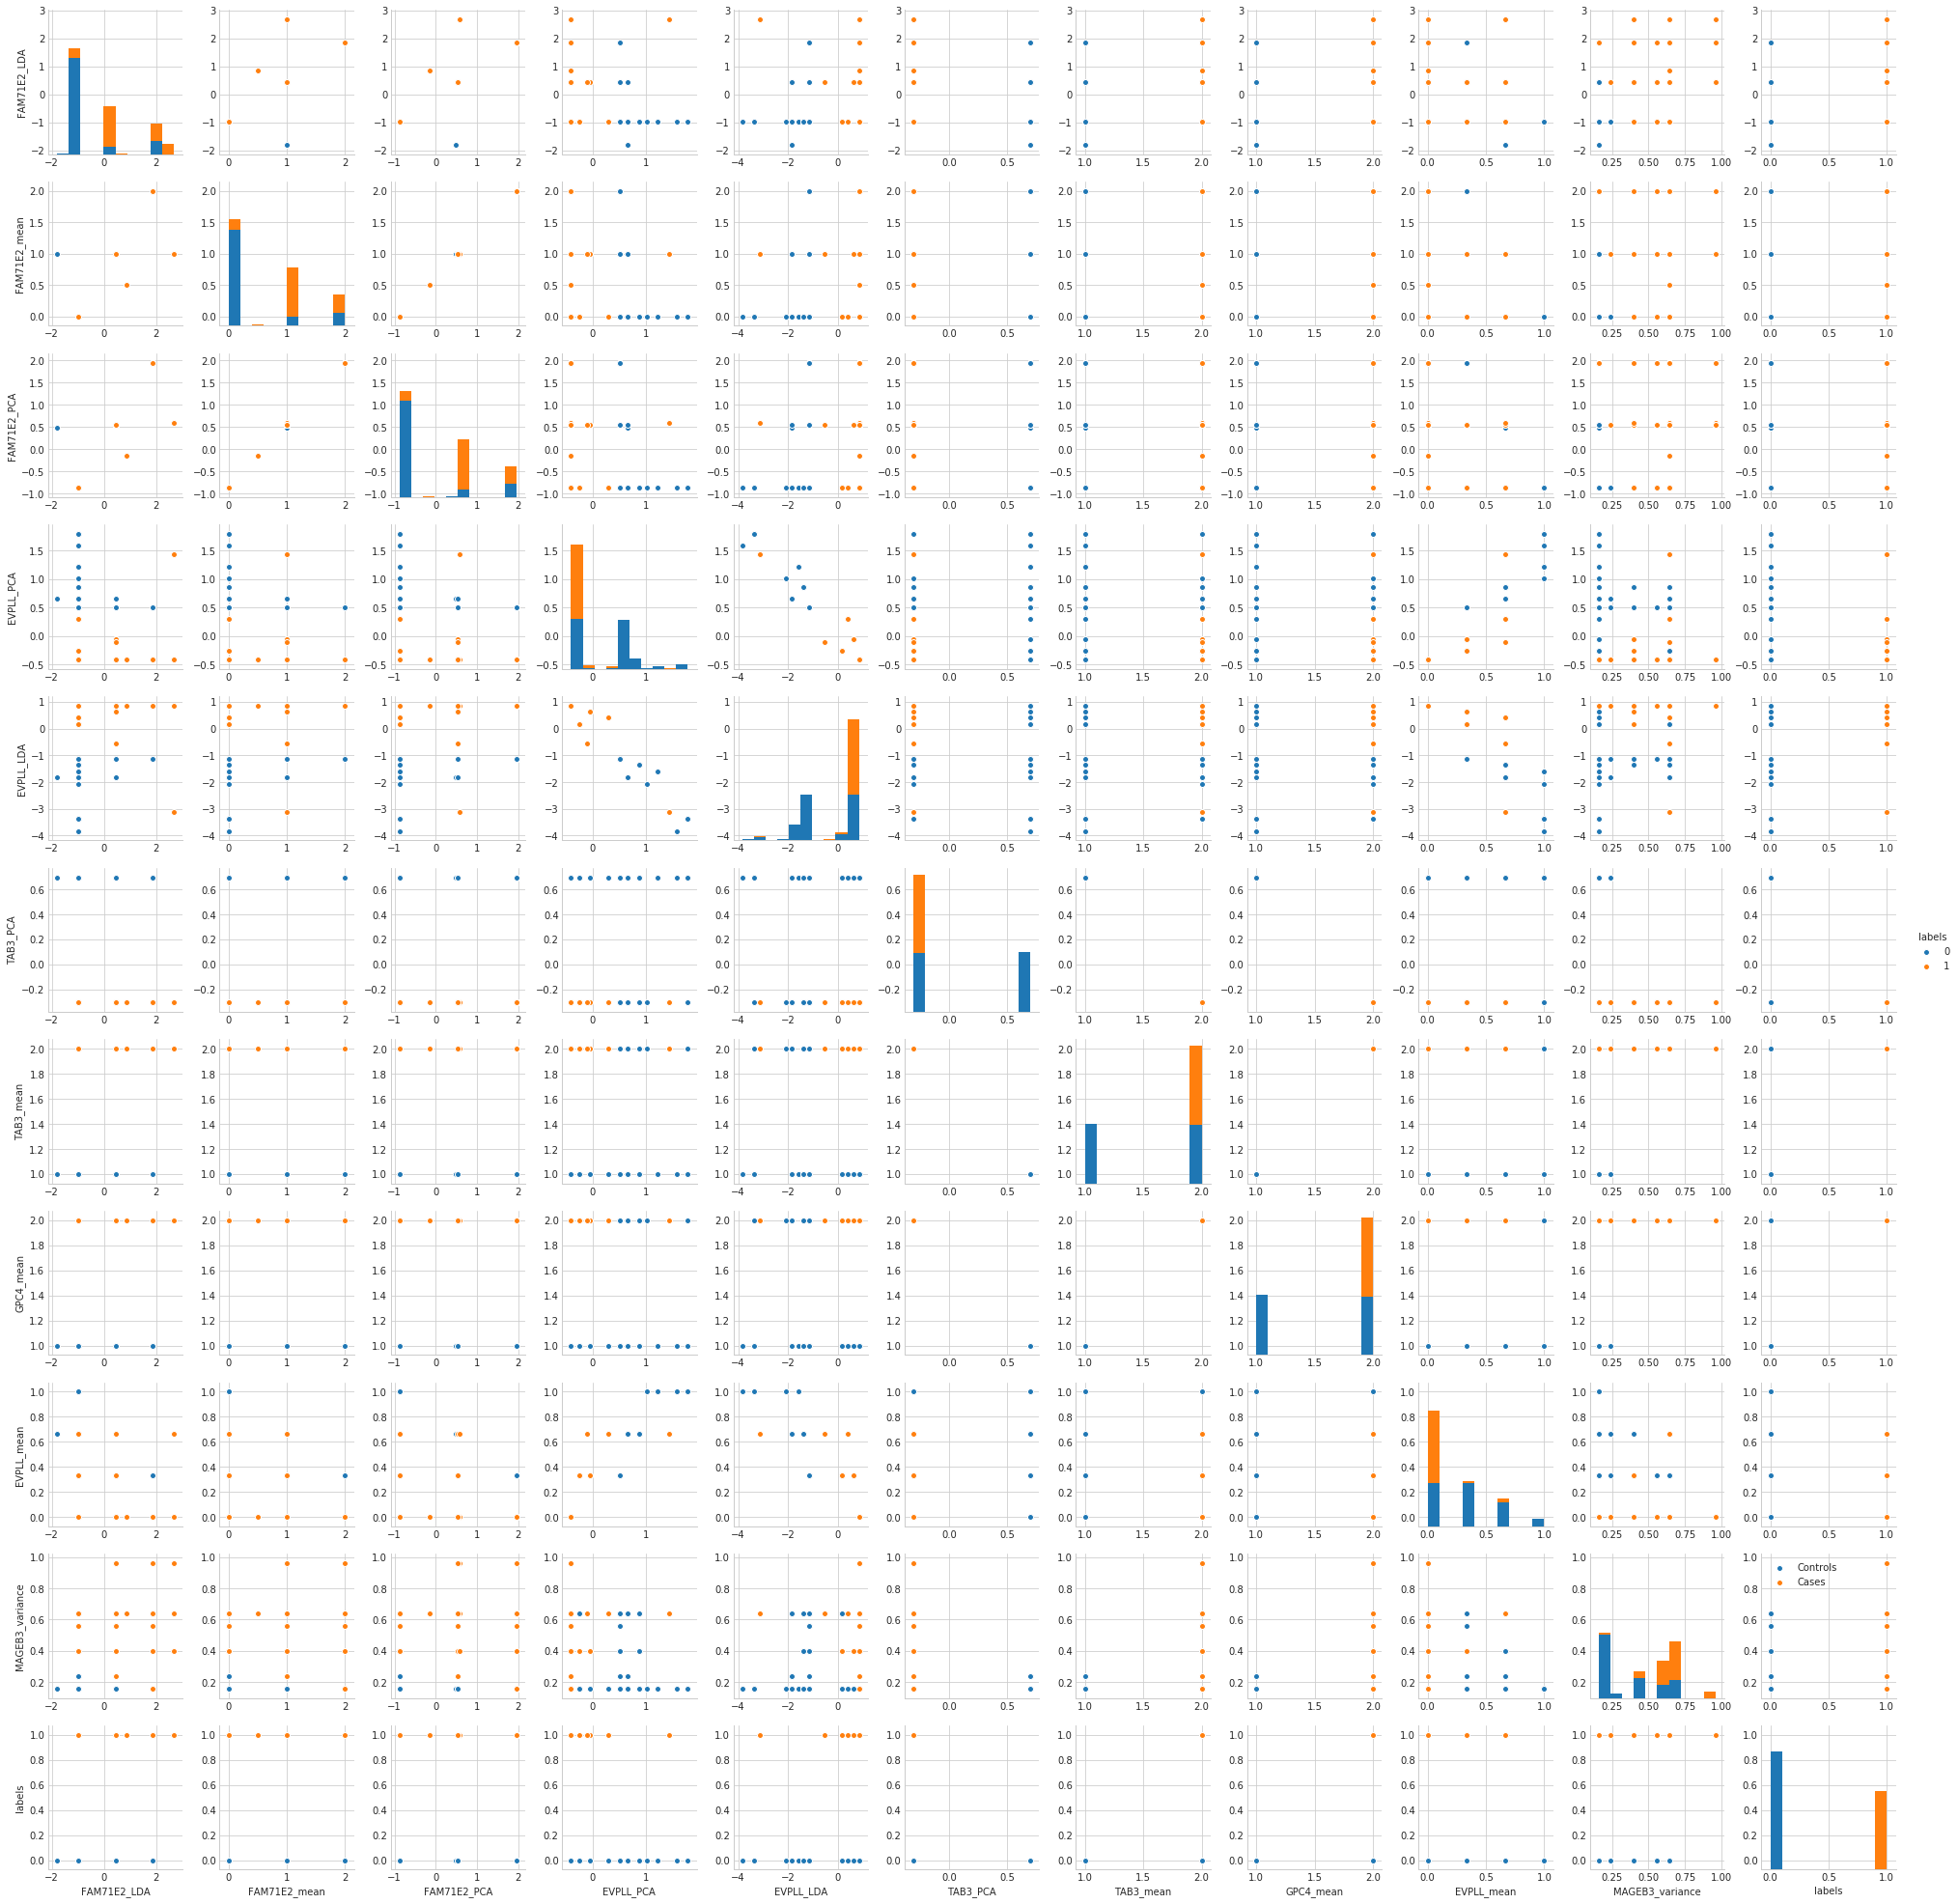

In [32]:
# top 10 features vs each other
test = top50_dataset[['FAM71E2_LDA', 'FAM71E2_mean', 'FAM71E2_PCA', 'EVPLL_PCA', 'EVPLL_LDA', 'TAB3_PCA', 'TAB3_mean', 'GPC4_mean', 'EVPLL_mean', 'MAGEB3_variance', 'labels']]

sns.pairplot(data = test, hue = 'labels')
plt.legend(['Controls', 'Cases'], loc = 0)
plt.savefig("../../data/plots/top_features_all_vs_all/1.png")

# 3. Testing an SVM classifier (with top 50 features)

In [ ]:
pre_X = top50_dataset.drop('labels', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

param_grid = [
    {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C':[0.25, 0.5, 0.75, 1, 1.5],
     'tol':[1e-3, 1e-4, 1e-5], 'gamma':[10, 25, 50, 75, 100, 150, 300, 500, 'auto'], 'degree':[1,2,3,5,10,13,17,25]}
]

svm_class_full = svm.SVC()
grid_search_full_svm = GridSearchCV(svm_class_full, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_full_svm.fit(X_train, y_train)

grid_search_full_svm.best_estimator_

In [33]:
'''
CLASSIFIER 1
svm.SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)
           
average f1-score: 0.94

CLASSIFIER 2


'''

pre_X = top50_dataset.drop('labels', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

f1_scores = []
for run in range(0,100):
    X_train, X_test, y_train, y_test = train_test_split(pre_X, dataset['labels'], test_size = 0.3)

    svm_classifier = svm.SVC(C=0.75, cache_size=200, class_weight=None, coef0=0.0,
              decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
              max_iter=-1, probability=False, random_state=None, shrinking=True,
              tol=0.001, verbose=False)

    print('Fitting model number: '  + str(run))
    svm_classifier.fit(X_train, y_train)

    print('Predicting...')
    #y_predicted = svm_classifier.predict(X_test)
    y_predicted = cross_val_predict(svm_classifier, X_test, y_test, cv=5)
    print('F1 Score:' + str(f1_score(y_test, y_predicted)))

    f1_scores.append(f1_score(y_test, y_predicted))

f1s = mean(f1_scores)
print('Final f1 score: ' + str(f1s))

Fitting model number: 0
Predicting...
F1 Score:0.93023255814
Fitting model number: 1
Predicting...
F1 Score:0.976744186047
Fitting model number: 2
Predicting...
F1 Score:0.947368421053
Fitting model number: 3
Predicting...
F1 Score:0.883720930233
Fitting model number: 4
Predicting...
F1 Score:0.810810810811
Fitting model number: 5
Predicting...
F1 Score:0.871794871795
Fitting model number: 6
Predicting...
F1 Score:0.944444444444
Fitting model number: 7
Predicting...
F1 Score:0.864864864865
Fitting model number: 8
Predicting...
F1 Score:0.96
Fitting model number: 9
Predicting...
F1 Score:0.866666666667
Fitting model number: 10
Predicting...
F1 Score:1.0
Fitting model number: 11
Predicting...
F1 Score:0.979591836735
Fitting model number: 12
Predicting...
F1 Score:0.936170212766
Fitting model number: 13
Predicting...
F1 Score:0.981132075472
Fitting model number: 14
Predicting...
F1 Score:0.888888888889
Fitting model number: 15
Predicting...
F1 Score:0.978723404255
Fitting model number: 16

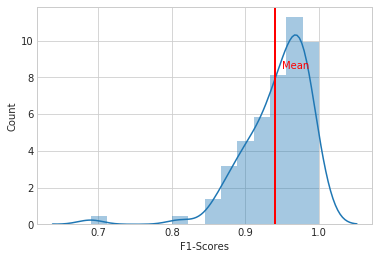

In [34]:
plt.figure()
sns.distplot(f1_scores)
plt.xlabel('F1-Scores')
plt.ylabel('Count')
plt.plot([0.94, 0.94], [0, 12], 'r-', lw=2)
plt.text(s = 'Mean', y = 8.5, x = 0.95, color = 'red')
plt.savefig("../../data/plots/f1s_top_50_rf/svm2.png") 
plt.show()